In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
import GPy
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

np.random.seed(1)
%matplotlib inline

In [2]:
vsp_data = pd.read_csv('../Data/vsp_input.tsv',sep='\t')
chrm1_data = vsp_data[vsp_data['AvgChrs']<=1]
chrm1_data = chrm1_data[chrm1_data['WSU_Old']!=17]
chrm1_data.head()

,Gene.names,Gene.description,AvgChrs,AT2_18M_F10,WSU_Old,Gene start (bp),Gene end (bp),gene length
46,Acadl,"acyl-Coenzyme A dehydrogenase, long-chain",0.341978,7.217256,28.021149,66830839,66863277,32438
53,Acbd3,acyl-Coenzyme A binding domain containing 3,0.924634,5.820596,24.807548,180726043,180754204,28161
88,Actr1b,"ARP1 actin-related protein 1B, centractin beta",0.187783,6.712477,25.467643,36698114,36714422,16308
90,Actr3,ARP3 actin-related protein 3,0.641597,7.504811,26.892912,125392905,125435727,42822
102,Adhfe1,"alcohol dehydrogenase, iron containing, 1",0.048929,2.993626,22.029780,9547948,9580673,32725


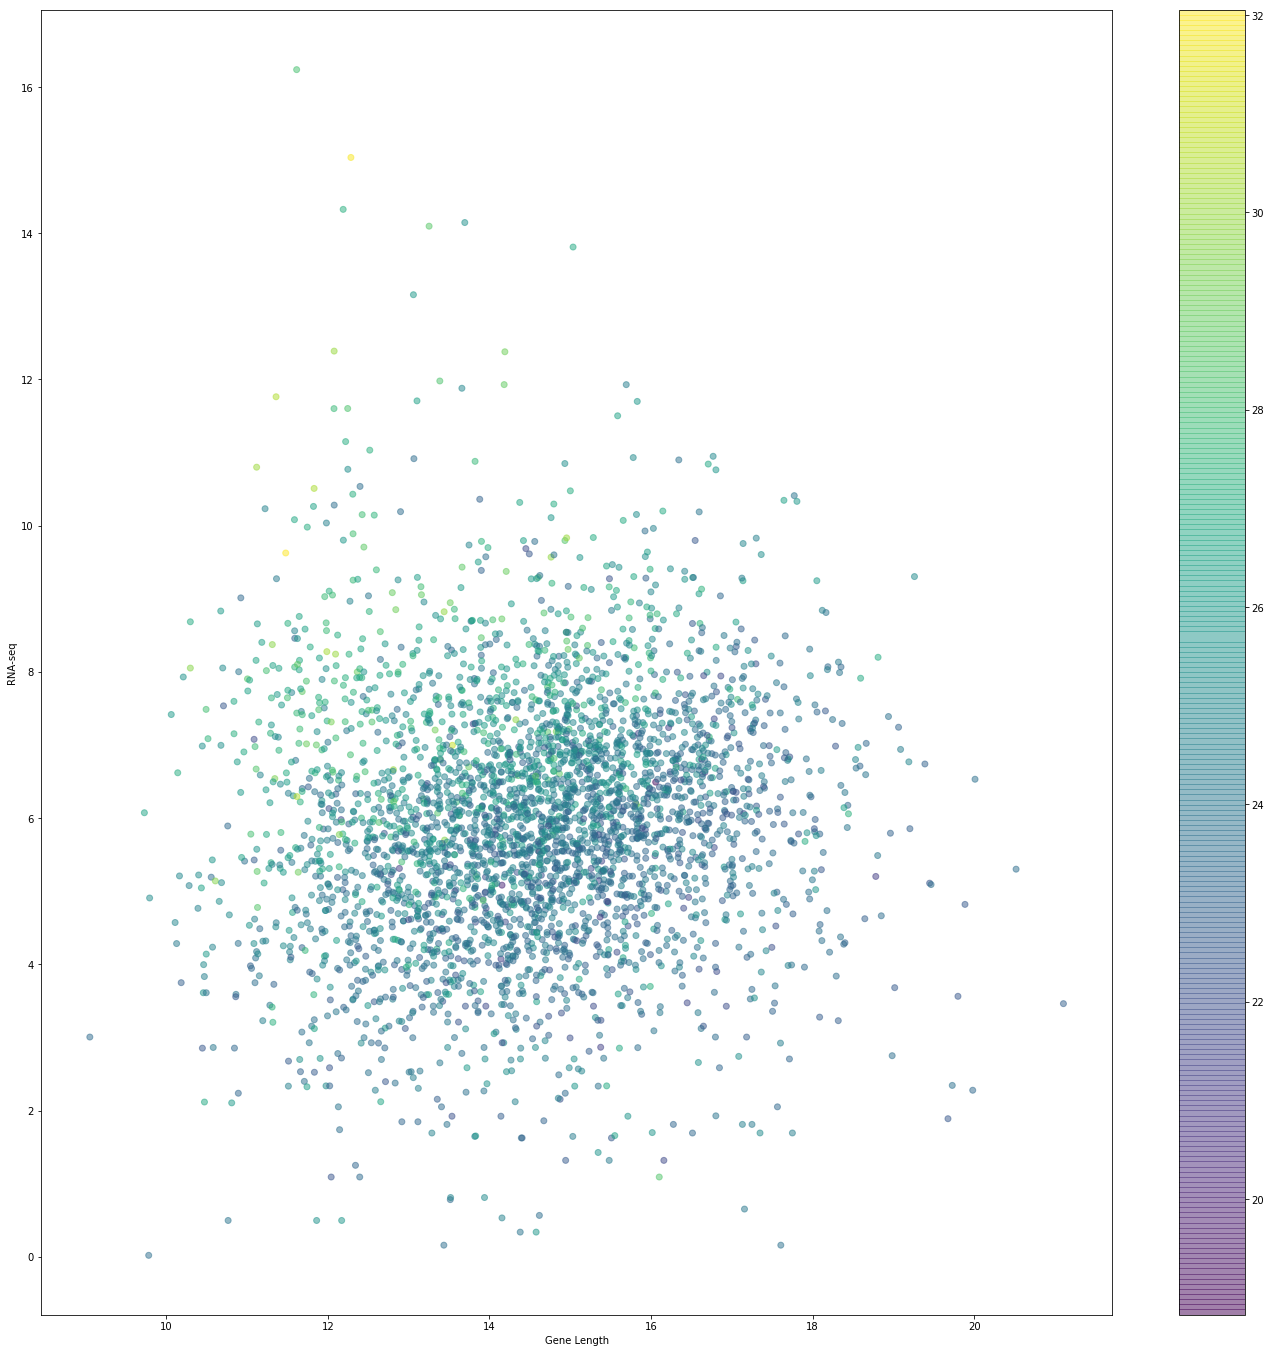

In [3]:
vsp_data=vsp_data[vsp_data['WSU_Old']!=17]
vsp_data=vsp_data[vsp_data['AT2_18M_F10']!=0]
fig = plt.figure()
fig.set_size_inches(24,24)
# ax = fig.add_subplot(211)
# sc = ax.scatter(vsp_data['AvgChrs'],vsp_data['AT2_18M_F10'],c=vsp_data['WSU_Old'],cmap = cm.viridis,alpha=0.5)
# ax.set_xlabel('Chromosome Position')
# ax.set_ylabel('RNA-seq')
# plt.colorbar(sc)

ax2 = fig.add_subplot(111)
sc = ax2.scatter(np.log2(vsp_data['gene length']),vsp_data['AT2_18M_F10'],c=vsp_data['WSU_Old'],cmap = cm.viridis,alpha=0.5)
ax2.set_xlabel('Gene Length')
ax2.set_ylabel('RNA-seq')
plt.colorbar(sc)

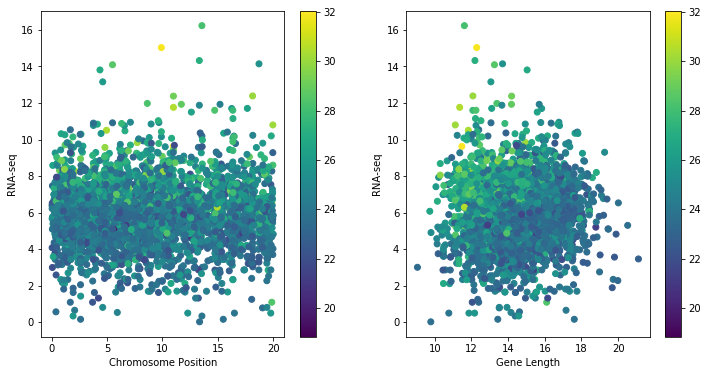

In [8]:
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(12,6)
ax = fig.add_subplot(121)
sc = ax.scatter(vsp_data['AvgChrs'],vsp_data['AT2_18M_F10'],c=vsp_data['WSU_Old'],cmap = cm.viridis)
ax.set_xlabel('Chromosome Position')
ax.set_ylabel('RNA-seq')
plt.colorbar(sc)

ax2 = fig.add_subplot(122)
sc = ax2.scatter(np.log2(vsp_data['gene length']),vsp_data['AT2_18M_F10'],c=vsp_data['WSU_Old'],cmap = cm.viridis)
ax2.set_xlabel('Gene Length')
ax2.set_ylabel('RNA-seq')
plt.colorbar(sc)

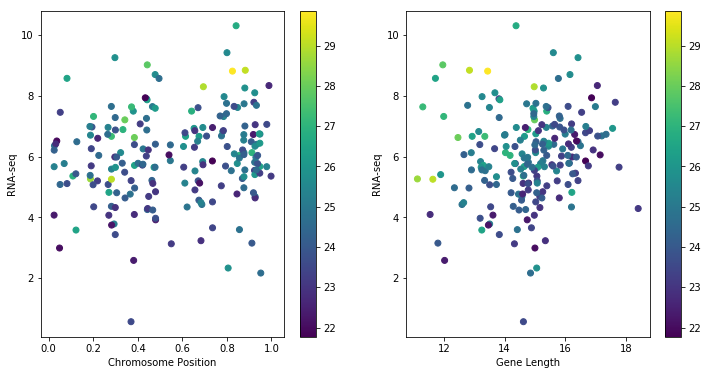

In [9]:
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(12,6)
ax = fig.add_subplot(121)
sc = ax.scatter(chrm1_data['AvgChrs'],chrm1_data['AT2_18M_F10'],c=chrm1_data['WSU_Old'],cmap = cm.viridis)
ax.set_xlabel('Chromosome Position')
ax.set_ylabel('RNA-seq')
plt.colorbar(sc)

ax2 = fig.add_subplot(122)
sc = ax2.scatter(np.log2(chrm1_data['gene length']),chrm1_data['AT2_18M_F10'],c=chrm1_data['WSU_Old'],cmap = cm.viridis)
ax2.set_xlabel('Gene Length')
ax2.set_ylabel('RNA-seq')
plt.colorbar(sc)

In [10]:
#Subset data into different partitions to test how much data the GP needs
data_percent = 0.8

msk = np.random.rand(len(chrm1_data)) < data_percent
train_chrm1 = chrm1_data[msk]
test_chrm1 = chrm1_data[~msk]

### Training Data

In [11]:
x=train_chrm1[['gene length','AT2_18M_F10']].values
x[:,0]=np.log2(x[:,0])
y=train_chrm1[['WSU_Old']].values
avg_protein = y.mean()
y -= avg_protein

### Testing Data

In [12]:
x_test = test_chrm1[['gene length','AT2_18M_F10']].values
x_test[:,0]=np.log2(x_test[:,0])

y_truth=test_chrm1[['WSU_Old']].values
#Make sure to use to original avg from the training data
y_truth -= avg_protein

### GP model using log2 gene length

 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


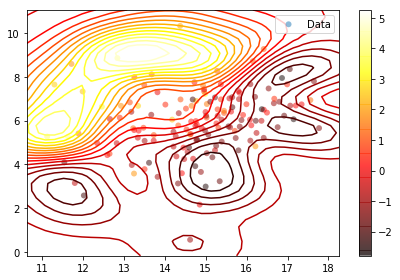

In [14]:
m = GPy.models.GPRegression(x,y)
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)

### GP model using avg chrm position

In [15]:
x=train_chrm1[['AvgChrs','AT2_18M_F10']].values
y=train_chrm1[['WSU_Old']].values
avg_protein = y.mean()
y -= avg_protein

In [16]:
m2 = GPy.models.GPRegression(x,y)

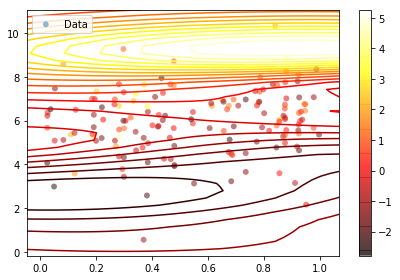

In [17]:
_ = m2.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)

## 4d GP

In [18]:
x=train_chrm1[['AvgChrs','gene length','AT2_18M_F10']].values
x[:,1]=np.log2(x[:,1])
y=train_chrm1[['WSU_Old']].values
avg_protein = y.mean()
y -= avg_protein

In [19]:
x_test = test_chrm1[['AvgChrs','gene length','AT2_18M_F10']].values
x_test[:,1]=np.log2(x_test[:,1])

In [20]:
m3 = GPy.models.GPRegression(x,y)

In [21]:
m3.optimize(messages=1, ipython_notebook=True)

In [22]:
predicted = m3.predict(x_test) #reurns mean and variance
y_predicted = predicted[0]

In [23]:
mean_squared_error(y_truth,y_predicted)

1.481417872054729

In [24]:
pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
print(pearsonr)

(array([0.52486219]), array([0.00025452]))


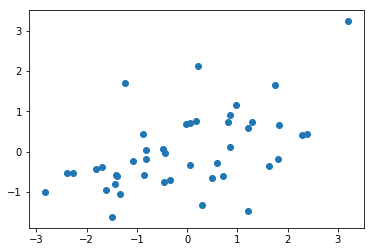

In [25]:
plt.scatter(y_truth,y_predicted)

# Sticking with gene length cont.

In [146]:
x=train_chrm1[['gene length','AT2_18M_F10']].values
x[:,0]=np.log2(x[:,0])
y=train_chrm1[['WSU_Old']].values
avg_protein = y.mean()
y -= avg_protein

In [147]:
x_test = test_chrm1[['gene length','AT2_18M_F10']].values
x_test[:,0]=np.log2(x_test[:,0])

y_truth=test_chrm1[['WSU_Old']].values
#Make sure to use to original avg from the training data
y_truth -= avg_protein

In [148]:
d = 2 # input dimension
var = 1. # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)
m = GPy.models.GPRegression(x,y,k)


#m = GPy.models.GPRegression(x,y)
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1.0,+ve,


Text(0.5, 1.0, 'rbf kernel with lengthscale 1.0,0.8 percent data')

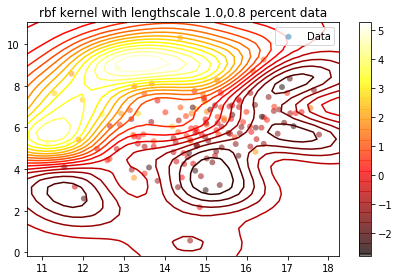

In [149]:
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)
ax.set_title(f'rbf kernel with lengthscale {m.rbf.lengthscale[0]},{data_percent} percent data')

In [150]:
predicted = m.predict(x_test) #reurns mean and variance
y_predicted = predicted[0]
mean_squared_error(y_truth,y_predicted)

1.4030327080890974

In [151]:
pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
print(pearsonr)

(array([0.53771976]), array([0.00016709]))


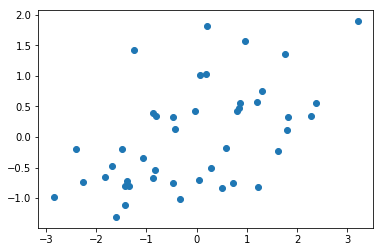

In [152]:
plt.scatter(y_truth,y_predicted)

# Optimized method

In [153]:
m.optimize(messages=1, ipython_notebook=True)
m

GP_regression.,value,constraints,priors
rbf.variance,5.365923865765756,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1.468562910618099,+ve,


In [154]:
m.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],5.41496028,+ve,
[1],5.65955443,+ve,


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Text(0.5, 1.0, 'rbf kernel with lengthscale 5.414960284938899,0.8 percent data')

 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


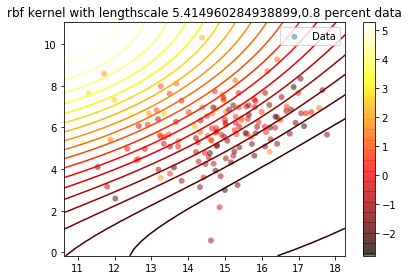

In [155]:
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)
ax.set_title(f'rbf kernel with lengthscale {m.rbf.lengthscale[0]},{data_percent} percent data')

AttributeError: 'Poly3DCollection' object has no attribute '_edgecolors2d'

 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


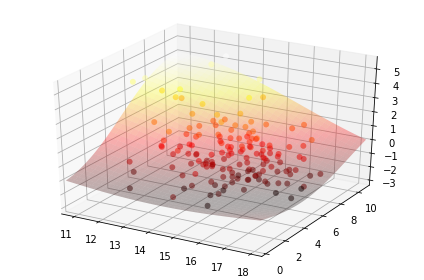

In [90]:
# _ = m.plot(projection='3d')
# ax = plt.gca()
# mappable=ax.collections[0]
# plt.colorbar(mappable)
# ax.set_title(f'rbf kernel with lengthscale {m.rbf.lengthscale[0]},{data_percent} percent data')

In [87]:
predicted = m.predict(x_test) #reurns mean and variance
y_predicted = predicted[0]
mean_squared_error(y_truth,y_predicted)

1.4708804608376136

In [88]:
pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
print(pearsonr)

(array([0.5283667]), array([0.00022732]))


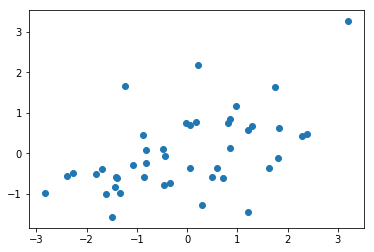

In [89]:
plt.scatter(y_truth,y_predicted)

# Very small length scale, see that it is overfitting

In [42]:
m.rbf.lengthscale[:] = 0.1
m

GP_regression.,value,constraints,priors
rbf.variance,5.454516702212306,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,1.4688794330159578,+ve,


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Text(0.5, 1.0, 'rbf kernel with lengthscale 0.1,0.8 percent data')

 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


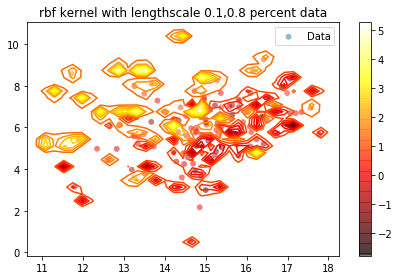

In [43]:
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)
ax.set_title(f'rbf kernel with lengthscale {m.rbf.lengthscale[0]},{data_percent} percent data')

# Using all the data

In [93]:
vsp_data=vsp_data[vsp_data['WSU_Old']!=17]
vsp_data=vsp_data[vsp_data['AT2_18M_F10']!=0]

### Split into training and testing

In [94]:
#Subset data into different partitions to test how much data the GP needs
data_percent = 0.8

msk = np.random.rand(len(vsp_data)) < data_percent
train_data = vsp_data[msk]
test_data = vsp_data[~msk]

In [135]:
#TRAINING
x = train_data[['gene length','AT2_18M_F10']].values
x[:,0]=np.log2(x[:,0])

y=train_data[['WSU_Old']].values
avg_protein = y.mean()
y -= avg_protein

#TESTING
x_test = test_data[['gene length','AT2_18M_F10']].values
x_test[:,0]=np.log2(x_test[:,0])

y_truth=test_data[['WSU_Old']].values
#Make sure to use to original avg from the training data
y_truth -= avg_protein


In [136]:
d = 2 # input dimension
var = 1. # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)
m = GPy.models.GPRegression(x,y,k)

#m = GPy.models.GPRegression(x,y)
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1.0,+ve,


In [137]:
# m = GPy.models.GPRegression(x,y)
# m

Text(0.5, 1.0, 'rbf kernel with lengthscale 1.0,0.8 percent data')

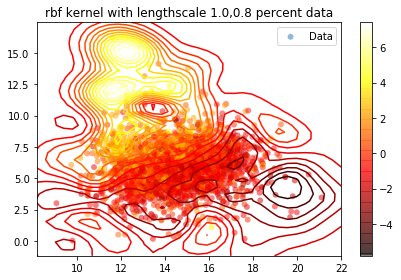

In [138]:
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)
ax.set_title(f'rbf kernel with lengthscale {m.rbf.lengthscale[0]},{data_percent} percent data')

In [139]:
predicted = m.predict(x_test) #reurns mean and variance
y_predicted = predicted[0]
mean_squared_error(y_truth,y_predicted)

1.5413198765694403

In [140]:
pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
print(pearsonr)

(array([0.50386211]), array([4.62089695e-45]))


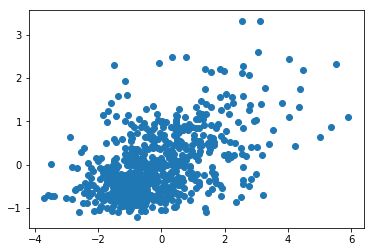

In [141]:
plt.scatter(y_truth,y_predicted)

In [142]:
m.optimize(messages=1, ipython_notebook=True)

In [143]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.7245908525827671,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1.6995767046903265,+ve,


In [144]:
m.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],1.64585979,+ve,
[1],3.49473871,+ve,


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Text(0.5, 1.0, 'rbf kernel with lengthscale 1.6458597900965561,0.8 percent data')

 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


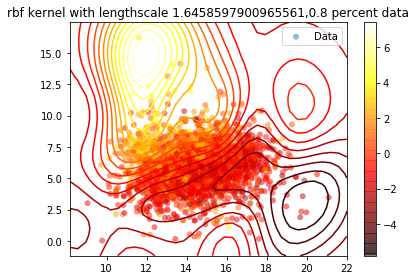

In [145]:
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)
ax.set_title(f'rbf kernel with lengthscale {m.rbf.lengthscale[0]},{data_percent} percent data')

In [104]:
predicted = m.predict(x_test) #reurns mean and variance
y_predicted = predicted[0]
mean_squared_error(y_truth,y_predicted)

1.5148866111945527

In [105]:
pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
print(pearsonr)

(array([0.5175013]), array([7.55917685e-48]))


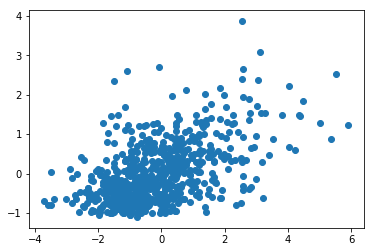

In [106]:
plt.scatter(y_truth,y_predicted)

## 4D using all the data

In [115]:
x=train_data[['AvgChrs','gene length','AT2_18M_F10']].values
x[:,1]=np.log2(x[:,1])
y=train_data[['WSU_Old']].values
avg_protein = y.mean()
y -= avg_protein

x_test = test_data[['AvgChrs','gene length','AT2_18M_F10']].values
x_test[:,1]=np.log2(x_test[:,1])

In [116]:
d = 3 # input dimension
var = 1. # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)
m3 = GPy.models.GPRegression(x,y,k)

#m = GPy.models.GPRegression(x,y)
m3

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,1.0,+ve,


In [117]:
#m3 = GPy.models.GPRegression(x,y)

In [118]:
m3.optimize(messages=1, ipython_notebook=True)

In [123]:
m3

GP_regression.,value,constraints,priors
rbf.variance,2.370683046938647,+ve,
rbf.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,1.7195872160879857,+ve,


In [124]:
m3.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],998.34920278,+ve,
[1],5.35824025,+ve,
[2],3.67947430,+ve,


In [119]:
predicted = m3.predict(x_test) #reurns mean and variance
y_predicted = predicted[0]
mean_squared_error(y_truth,y_predicted)

1.4786658168381541

In [120]:
pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
print(pearsonr)

(array([0.53363467]), array([2.60172655e-51]))


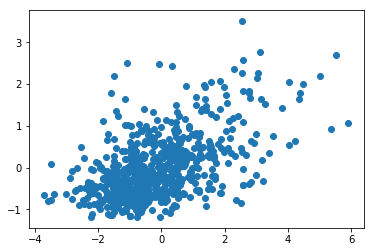

In [121]:
plt.scatter(y_truth,y_predicted)

### Repeated runs on different partitions

In [165]:
pearsons = []
spearmans = []
mse = []
lengthscales = []
for i in tqdm(range(50)):
    #Subset data into different partitions to test how much data the GP needs
    data_percent = 0.8

    msk = np.random.rand(len(chrm1_data)) < data_percent
    train_chrm1 = chrm1_data[msk]
    test_chrm1 = chrm1_data[~msk]

    x=train_chrm1[['gene length','AT2_18M_F10']].values
    x[:,0]=np.log2(x[:,0])
    y=train_chrm1[['WSU_Old']].values
    avg_protein = y.mean()
    y -= avg_protein

    x_test = test_chrm1[['gene length','AT2_18M_F10']].values
    x_test[:,0]=np.log2(x_test[:,0])

    y_truth=test_chrm1[['WSU_Old']].values
    #Make sure to use to original avg from the training data
    y_truth -= avg_protein

    d = 2 # input dimension
    var = 1. # variance
    theta = 1 # lengthscale
    k = GPy.kern.RBF(d,var,theta,ARD=True)
    m = GPy.models.GPRegression(x,y,k)
    m.optimize(messages=1, ipython_notebook=True)

    predicted = m.predict(x_test) #reurns mean and variance
    y_predicted = predicted[0]
    mse.append(mean_squared_error(y_truth,y_predicted))
    pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
    spearmanr = scipy.stats.spearmanr(y_truth,y_predicted)
    pearsons.append(pearsonr)
    spearmans.append(spearmanr)
    lengthscales.append(m.rbf.lengthscale.values)


  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:02<01:45,  2.16s/it]


  4%|▍         | 2/50 [00:06<02:17,  2.87s/it]


  6%|▌         | 3/50 [00:09<02:12,  2.81s/it]


  8%|▊         | 4/50 [00:13<02:28,  3.23s/it]


 10%|█         | 5/50 [00:17<02:36,  3.48s/it]


 12%|█▏        | 6/50 [00:20<02:27,  3.36s/it]


 14%|█▍        | 7/50 [00:22<02:09,  3.01s/it]


 16%|█▌        | 8/50 [00:25<01:56,  2.78s/it]


 18%|█▊        | 9/50 [00:29<02:10,  3.18s/it]


 20%|██        | 10/50 [00:32<02:06,  3.16s/it]


 22%|██▏       | 11/50 [00:35<02:03,  3.16s/it]


 24%|██▍       | 12/50 [00:38<01:53,  2.99s/it]


 26%|██▌       | 13/50 [00:41<01:57,  3.18s/it]


 28%|██▊       | 14/50 [00:46<02:10,  3.62s/it]


 30%|███       | 15/50 [00:48<01:50,  3.15s/it]


 32%|███▏      | 16/50 [00:50<01:40,  2.94s/it]


 34%|███▍      | 17/50 [00:54<01:47,  3.27s/it]


 36%|███▌      | 18/50 [00:57<01:36,  3.00s/it]


 38%|███▊      | 19/50 [01:02<01:53,  3.67s/it]


 40%|████      | 20/50 [01:05<01:47,  3.59s/it]


 42%|████▏     | 21/50 [01:09<01:48,  3.73s/it]


 44%|████▍     | 22/50 [01:14<01:53,  4.06s/it]


 46%|████▌     | 23/50 [01:24<02:36,  5.79s/it]


 48%|████▊     | 24/50 [01:29<02:24,  5.57s/it]


 50%|█████     | 25/50 [01:32<01:56,  4.66s/it]


 52%|█████▏    | 26/50 [01:35<01:40,  4.19s/it]


 54%|█████▍    | 27/50 [01:38<01:29,  3.91s/it]


 56%|█████▌    | 28/50 [01:42<01:28,  4.00s/it]


 58%|█████▊    | 29/50 [01:44<01:11,  3.43s/it]


 60%|██████    | 30/50 [01:49<01:18,  3.91s/it]


 62%|██████▏   | 31/50 [01:52<01:07,  3.56s/it]


 64%|██████▍   | 32/50 [01:56<01:06,  3.68s/it]


 66%|██████▌   | 33/50 [01:59<00:57,  3.38s/it]


 68%|██████▊   | 34/50 [02:01<00:50,  3.15s/it]


 70%|███████   | 35/50 [02:05<00:47,  3.15s/it]


 72%|███████▏  | 36/50 [02:08<00:46,  3.31s/it]


 74%|███████▍  | 37/50 [02:13<00:48,  3.71s/it]


 76%|███████▌  | 38/50 [02:17<00:44,  3.69s/it]


 78%|███████▊  | 39/50 [02:22<00:45,  4.11s/it]


 80%|████████  | 40/50 [02:24<00:36,  3.61s/it]


 82%|████████▏ | 41/50 [02:27<00:31,  3.51s/it]


 84%|████████▍ | 42/50 [02:32<00:30,  3.84s/it]


 86%|████████▌ | 43/50 [02:35<00:24,  3.50s/it]


 88%|████████▊ | 44/50 [02:42<00:27,  4.66s/it]


 90%|█████████ | 45/50 [02:44<00:19,  3.89s/it]


 92%|█████████▏| 46/50 [02:47<00:14,  3.50s/it]


 94%|█████████▍| 47/50 [02:49<00:09,  3.16s/it]


 96%|█████████▌| 48/50 [02:52<00:05,  2.97s/it]


 98%|█████████▊| 49/50 [02:56<00:03,  3.33s/it]


100%|██████████| 50/50 [03:01<00:00,  3.81s/it]


In [166]:
pearsons

[(array([0.44467923]), array([0.00317262])),
 (array([0.67143549]), array([2.11007067e-06])),
 (array([0.60489088]), array([1.73571798e-05])),
 (array([0.62584839]), array([1.56896256e-05])),
 (array([0.64735003]), array([8.43048133e-06])),
 (array([0.52952062]), array([0.00012957])),
 (array([0.43221063]), array([0.00673095])),
 (array([0.61265158]), array([0.00015074])),
 (array([0.67249552]), array([5.74130066e-07])),
 (array([0.39733497]), array([0.00833171])),
 (array([0.7095449]), array([2.06037079e-07])),
 (array([0.61718581]), array([2.21709749e-05])),
 (array([0.67760331]), array([4.09082202e-06])),
 (array([0.32943627]), array([0.06559131])),
 (array([0.49505511]), array([0.00054569])),
 (array([0.41001616]), array([0.02197331])),
 (array([0.62608427]), array([5.48468975e-06])),
 (array([0.51844588]), array([0.00085474])),
 (array([0.47053741]), array([0.00049323])),
 (array([0.40722072]), array([0.01683439])),
 (array([0.5905553]), array([0.00018798])),
 (array([0.49654981])

In [169]:
p_r = [vals[0][0] for vals in pearsons]

In [172]:
max(p_r)

0.7095448995121275

In [173]:
min(p_r)

0.2644437233039192

In [175]:
np.mean(p_r)

0.5272731952076647

In [178]:
s_r = [vals[0] for vals in spearmans]

In [180]:
max(s_r)

0.7187617260787993

In [181]:
min(s_r)

0.29728739002932547

In [ ]:
pearsons
spearmans
mse
lengthscales 

In [184]:
lengthscales

[array([1.49544418, 0.72070825]),
 array([1.78986876, 3.97135185]),
 array([2.39004605, 3.75930661]),
 array([5.15021501, 5.82657727]),
 array([5.54796642, 5.58039045]),
 array([1.33178316, 1.09164676]),
 array([1.56167661, 0.73934283]),
 array([1.5506312 , 1.03388981]),
 array([4.93710447, 4.04886814]),
 array([1.64070165, 0.67605621]),
 array([5.74825876, 5.86553809]),
 array([4.83971431, 4.73831942]),
 array([5.39208688, 5.33411492]),
 array([5.10679223, 5.53523878]),
 array([1.50854455, 0.99938036]),
 array([1.54762978, 1.2114863 ]),
 array([4.362967  , 5.21920399]),
 array([1.34076441, 0.84044908]),
 array([4.70452263, 4.54358431]),
 array([4.85567567, 2.01398666]),
 array([4.76315862, 1.70504638]),
 array([4.7463404 , 4.41578508]),
 array([6.6632661, 5.7222877]),
 array([4.42902855, 1.67103512]),
 array([1.63330554, 1.11319067]),
 array([5.41859906, 5.1767769 ]),
 array([1.47918805, 0.99252788]),
 array([4.14340254, 4.63303262]),
 array([1.35165288, 1.19258691]),
 array([6.108466

In [183]:
lengthscales[10]

array([5.74825876, 5.86553809])